u3m -> mtROS = 0.5

In [1]:
import PyDSTool
from PyDSTool.Toolbox import phaseplane as pp
import matplotlib
from pylab import *
import copy
import math
matplotlib.rcParams.update({'font.size': 30})
from matplotlib.lines import Line2D

from mpi4py import MPI
myrank = MPI.COMM_WORLD.Get_rank()
nprocs = MPI.COMM_WORLD.Get_size()
stat = MPI.Status()

from bif_functions import *


In [2]:
DSargsF = PyDSTool.args(name='bothFull',checklevel=2)
DSargsF.fnspecs = {'H':(['X','X0','nX','lamdaX'],'lamdaX+(1.-lamdaX)/(1.+(X/X0)**nX)'),
                  'Z':(['mzX','uX','u0X','nuX','kzX','gzX'],'gzX*mzX*L(uX,u0X,nuX)/kzX'),
                  'M' : (['i','n','x','x0'],'(x/x0)**i/(1+(x/x0))**n'),
                  'indL': (['i'],'if(i==0,li0,if(i==1,li1,if(i==2,li2,if(i==3,li3,if(i==4,li4,if(i==5,li5,li6))))))'),
                  'indLh': (['i'],'if(i==0,lih0,if(i==1,lih1,if(i==2,lih2,lih2)))'),
                  'indYm': (['i'],'if(i==0,ymi0,if(i==1,ymi1,if(i==2,ymi2,if(i==3,ymi3,if(i==4,ymi4,if(i==5,ymi5,ymi6))))))'),
                  'indYmh': (['i'],'if(i==0,ymih0,if(i==1,ymih1,if(i==2,ymih2,ymih2)))'),
                  'indYu': (['i'],'if(i==0,yui0,if(i==1,yui1,if(i==2,yui2,if(i==3,yui3,if(i==4,yui4,if(i==5,yui5,yui6))))))'),
                  'indYuh': (['i'],'if(i==0,yuih0,if(i==1,yuih1,if(i==2,yuih2,yuih2)))'),
                  'combination':(['k','n'],'special_gamma(n+1)/special_gamma(k+1)/special_gamma(n-k+1)'),
                  'combinationU':(['k','n'],'k*special_gamma(n+1)/special_gamma(k+1)/special_gamma(n-k+1)'),
                  'L' : (['X','X0','nX'],'sum(i,0,6,li[i]*combination([i],nX)*M([i],nX,X,X0))'),
                  'Lh' : (['X','X0','nX'],'sum(i,0,2,lih[i]*combination([i],nX)*M([i],nX,X,X0))'),
                  'Ym' : (['X','X0','nX'],'sum(i,0,6,ymi[i]*combination([i],nX)*M([i],nX,X,X0))'),
                  'Ymh' : (['X','X0','nX'],'sum(i,0,2,ymi[i]*combination([i],nX)*M([i],nX,X,X0))'),
                  'Yu' : (['X','X0','nX'],'sum(i,0,6,yui[i]*combinationU([i],nX)*M([i],nX,X,X0))'),
                  'L3' : (['X','X0','nX'],'sum(i,0,2,li[i]*combination([i],nX)*M([i],nX,X,X0))'),
                  'Ym3' : (['X','X0','nX'],'sum(i,0,2,ymi[i]*combination([i],nX)*M([i],nX,X,X0))'),
                  'Yu3' : (['X','X0','nX'],'sum(i,0,2,yui[i]*combinationU([i],nX)*M([i],nX,X,X0))'),
                  'Yuh' : (['X','X0','nX'],'sum(i,0,2,yuih[i]*combinationU([i],nX)*M([i],nX,X,X0))'),
                  'R':(['R1','R2'],'R1+R2'),
                  'CompRmt':(['yyX', 'gnX', 'hX', 'h0rmtX', 'nhmtX', 'AX', 'A0rmtX',  'namtX'],'yyX*(gnX+(AX/A0rmtX)**namtX)/(1.+(hX/h0rmtX)**nhmtX+(AX/A0rmtX)**namtX)'),
                  'CompRn':(['g0X', 'hX', 'h0rnX', 'nhnX', 'ghnX', 'AX', 'A0rnX', 'ganX',  'nanxX'],'(g0X+ghnX*(hX/h0rnX)**nhnX+ganX*(AX/A0rnX)**nanxX)/(1.+(hX/h0rnX)**nhnX+(AX/A0rnX)**nanxX)')
                        }


In [3]:
DSargsF.varspecs = {'u':'gu*H(Z(mz,u,u0,nu,kz,gz),Z0u,nzu,lamdazu)*H(S,S0u,nsu,lamdaSu)*H(h,h0u,nhu,lamdahu)*H(A,A0u,nAu,lamdaAu)-mz*Yu(u,u0,nu)-mh*Yuh(0,u0,nuh)-ku*u',
                   'mz':'gmz*H(Z(mz,u,u0,nu,kz,gz),Z0m,nzm,lamdaZm)*H(S,S0m,nsm,lamdaSm)*H(A,A0m,nAm,lamdaAm)-mz*Ym(u,u0,nu)-kmz*mz',
                   'ms':'gms*H(S,S0ms,nsms,lamdaSms)*H(I,I0m,nIm,lamdaIm)*H(h,h0ms,nhms,lamdahms)*H(A,A0ms,nAms,lamdaAms)-ms*Ym(u3,u30,nu3)-kms*ms',
                   'u3':'gu3*H(Z(mz,u,u0,nu,kz,gz),Z0u3,nzu3,lamdazu3)*H(S,S0u3,nsu3,lamdaSu3)-ms*Yu3(u3,u30,nu3)-ku3*u3',
                   'S':'gs*ms*L3(u3,u30,nu3)-ks*S',
                   'A':'ga*H(R(Rmt,Rnox),R0ra,nra,lambdara)*H(h,h0ha,nha,lambdaha)*H(A,A0aa,naa,lambdaaa)-ka*A',
                   'h':'gh*mh*Lh(0.,u0,nuh)-kh*h',
                   'Rmt':'grm*H(A,A0aR,nar,lambdaar)*CompRmt(y,gn,h,h0hrm,nhrm,A,A0rm,narm)-krm*Rmt*H(u3,nu30rm,n3m,lamda3m)',
                   'Rnox':'grn*CompRn(gn,h,h0hrn,nhrn,g1,A,A0rn,g2,narn)-krn*Rnox*H(u3,nu30rn,n3n,lamda3n)',
                   'mh':'gmh*H(A,A0ah,nah,lambdaah)-kmh*mh*H(h,h0hh,nhh,lambdahh)*H(R(Rmt,Rnox),R0rh,nrh,lambdarh)-mh*Ymh(0.,u0,nuh)'
                }



In [4]:

DSargsF.pars ={'gz':100.,'gu':2100.,'gms':90.,'gu3':1350.,'gs':100.,'gmz':11.,'grn':40.,'grm':150.,'ga':30.,'gn':0.2,'g1':5.,'g2':0.2,'gmh':10.,'gh':1.5,'y':8.,
                'ks':0.125,'kz':0.1,'ku':0.05,'kmz':0.5,'kms':0.5,'ku3':0.05,'ka':0.2,'krm':5.,'krn':5.,'kmh':.143,'kh':1.75,
                'Z0u':220000.,'I0m':50000.,'S0ms':200000.,'u30':10000.,'S0u3':300000.,'h0ha':250.,'A0aa':350.,'h0hrm':200.,'h0hrn':250.,'A0rn':150.,'A0rm':150.,
                'Z0u3':600000.,'Z0m':25000,'S0u':180000.,'S0m':180000.,'u0':10000.,'h0u':200.,'A0u':300.,'A0m':300.,'A0ms':300.,'A0aR':350.,'R0ra':100.,
                'h0ms':200.,'nu30rn':10000.,'nu30rm':10000.,'A0ah':250.,'R0rh':300.,'h0hh':80.,
                'lamdahu':1.,'lamdaAu':1.,'lamdaAms':1.,'lamdahms':1.,'lamdaAm':1.,'lamda3n':1.,'lamda3m':0.5,
                'lamdazu':0.1,'lamdaSu':0.1,'lamdaIm':10.,'lamdaSms':0.1,'lamdazu3':0.2,'lamdaSu3':0.1,'lamdaZm':7.5,'lamdaSm':10.,
                'lambdarh':0.2,'lambdahh':0.1,'lambdaah':0.1,'lambdaar':0.25,'lambdara':8.,'lambdaha':0.1,'lambdaaa':0.2,
                'nu3':2,'nzu3':2,'nsms':1,'nIm':2,'nsu3':1,'naa':2,'nra':4,'nha':1,'nar':2,'narm':4,'nhrm':2,'nhrn':2,
                'nzu':3,'nsu':2,'nzm':2,'nsm':2,'nu':6,'nuh':2,'nhu':1,'nAu':1,'nAm':2,'nAms':2,'nhms':2,
                'narn':2,'nah':1,'nrh':4,'nhh':4,'n3m':3,'n3n':2,
                'I':50000.,
                'ymi0':0.,'ymi1':0.04,'ymi2':0.2,'ymi3':1.,'ymi4':1.,'ymi5':1.,'ymi6':1.,
                'yui0':0.,'yui1':0.005,'yui2':0.05,'yui3':0.5,'yui4':0.5,'yui5':0.5,'yui6':0.5,
                'li0':1.,'li1':0.6,'li2':0.3,'li3':0.1,'li4':0.05,'li5':0.05,'li6':0.05,
                'ymih0':0.,'ymih1':0.04,'ymih2':0.2,
                'yuih0':0.,'yuih1':0.005,'yuih2':0.05,
                'lih0':1.,'lih1':0.6,'lih2':0.3
                }


In [5]:
DSargsF.ics={'u':1000,'mz':1000,'S':200000,'ms':2000,'u3':4000,'h':100,'A':100,'Rnox':100,'Rmt':100,'mh':100}
DSargsF.xdomain = {'u':[0,20000],'mz':[0,1500],'S':[0,400000],'ms':[0,20000],'u3':[0,20000],'A':[0,1000],'h':[0,1000],'Rmt':[0,1000],'Rnox':[0,1000],'mh':[0,1000]}
DSargsF.tdomain = [0,5000]
DSargsF.algparams = {'init_step':0.4}
new_domains = {'u':[0,20000],'mz':[0,1500],'S':[0,400000],'ms':[0,20000],'u3':[0,20000],'A':[0,1000],'h':[0,1000],'Rmt':[0,1000],'Rnox':[0,1000],'mh':[0,1000]}




In [6]:
ode = PyDSTool.Generator.Vode_ODEsystem(DSargsF)

In [ ]:
Ffixed_points = pp.find_fixedpoints(ode,n=25,maxsearch=1e+5,eps=1e-5)#10)

In [ ]:
tmp_Ffp=[]
for i in range(len(Ffixed_points)):
    tmp_Ffp+=[Ffixed_points[i].values()]
tmp_Ffp = np.array(tmp_Ffp)
columns=np.array(Ffixed_points[0].keys())
iA = np.argwhere(columns=='A')[0][0]
ih = np.argwhere(columns=='h')[0][0]
iu = np.argwhere(columns=='u')[0][0]
imz = np.argwhere(columns=='mz')[0][0]
imr = np.argwhere(columns=='Rmt')[0][0]
inr = np.argwhere(columns=='Rnox')[0][0]
imh = np.argwhere(columns=='mh')[0][0]
iu3 = np.argwhere(columns=='u3')[0][0]
iS = np.argwhere(columns=='S')[0][0]
ims = np.argwhere(columns=='ms')[0][0]

print iA,ih,iu,imz

plt.plot(tmp_Ffp[:,iA],tmp_Ffp[:,imz],'*')
plt.show()
plt.plot(tmp_Ffp[:,iu],tmp_Ffp[:,ih],'*')
plt.show()
plt.plot(tmp_Ffp[:,iA],tmp_Ffp[:,ih],'*')
plt.show()
plt.plot(tmp_Ffp[:,iu],tmp_Ffp[:,imz],'*')
plt.show()

In [ ]:
def new_reducefp(tmp_Ffp):
    tmpb = copy.deepcopy(tmp_Ffp)
    finalV=[]
    i=0
    while i<len(tmpb) and i<50:
        dat= np.sum((tmpb[i]-tmpb[:])**2,axis=1)<100
        finalV+=[tmpb[i]]
        inds = np.argwhere(dat==1)[:,0]
        tmpb=np.delete(tmpb,inds,axis=0)
        i+=1

    for i in range(4):
        dat= np.sum((tmp_Ffp[i]-tmp_Ffp[:])**2,axis=1)<100

        plt.plot(dat,'*')

    finalV=np.array(finalV)
    plt.close()
    plt.plot(np.array(finalV)[:,iA],np.array(finalV)[:,imz],'o',markersize=10)
    
    finalArr = []
    for i in range(len(finalV)):
        finalArr+=[{'A':finalV[i][iA],'h':finalV[i][ih],'u':finalV[i][iu],'mz':finalV[i][imz],'Rmt':finalV[i][imr],
                    'Rnox':finalV[i][inr],'mh':finalV[i][imh],'u3':finalV[i][iu3],'S':finalV[i][iS],'ms':finalV[i][ims]}]
    return finalArr

In [ ]:
fixed_points = new_reducefp(tmp_Ffp)
print fixed_points[0]
print Ffixed_points[0]

In [ ]:
PyContF=getCont(DSargsF,fixed_points,2000,1e+0,'u3',[0,10000])


In [ ]:
sol_cont = PyContF['EMT-MR'].sol

In [11]:
solC_mz = nullclines('mz',DSargsF,fixed_points,new_domains,1000)

B Point found 
B Point found 


In [12]:
solC_a = nullclines('A',DSargsF,fixed_points,new_domains,1000)

LP Point found 
Test function going crazy:  class Hopf_Bor(BorderMethod, BiAltMethod) 

LP Point found 
Test function going crazy:  class Hopf_Bor(BorderMethod, BiAltMethod) 

Test function going crazy:  class Hopf_Bor(BorderMethod, BiAltMethod) 

B Point found 
B Point found 


In [13]:
solC_u = nullclines('u',DSargsF,fixed_points,new_domains,1000)

B Point found 
B Point found 


In [14]:
solC_h = nullclines('h',DSargsF,fixed_points,new_domains,1000)

B Point found 
LP Point found 
Test function going crazy:  <PyDSTool.PyCont.TestFunc.B_Check object at 0x7fe25564cc10> 

B Point found 


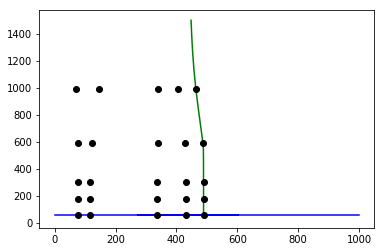

In [15]:
plt.plot(solC_a['A'],solC_a['mz'],color='b',label='dA/dt=0')
plt.plot(solC_mz['A'],solC_mz['mz'],color='g',label='dmz/dt=0')
for i in range(len(fixed_points)):
    plt.plot(fixed_points[i]['A'],fixed_points[i]['mz'],'ko')
#plt.ylim(0,100)

(0, 600)

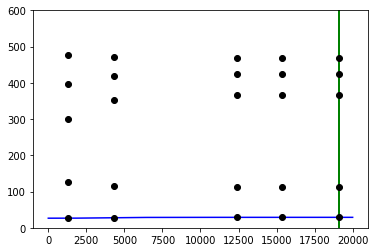

In [23]:
plt.plot(solC_u['u'],solC_u['h'],color='b',label='du/dt=0')
plt.plot(solC_h['u'],solC_h['h'],color='g',label='dh/dt=0')
for i in range(len(fixed_points)):
    plt.plot(fixed_points[i]['u'],fixed_points[i]['h'],'ko')
plt.ylim(0,600)

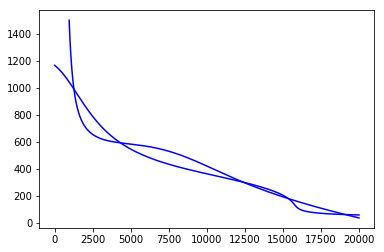

In [17]:
plt.plot(solC_u['u'],solC_u['mz'],color='b',label='du/dt=0')
plt.plot(solC_mz['u'],solC_mz['mz'],color='b',label='dmz/dt=0')


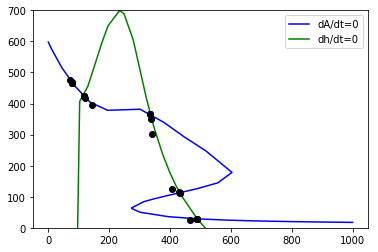

In [26]:
plt.plot(solC_a['A'],solC_a['h'],color='b',label='dA/dt=0')
plt.plot(solC_h['A'],solC_h['h'],color='g',label='dh/dt=0')
for i in range(len(fixed_points)):
    plt.plot(fixed_points[i]['A'],fixed_points[i]['h'],'ko')

plt.ylim(0,700)
plt.legend()